In [1]:
import warnings; warnings.simplefilter('ignore')
import os, shutil, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import seaborn as sns
import tensorflow as tf
import keras

from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
#The user should modify manually the IATA codes for the specific airports that will be predicted
Airport='BOG'

In [3]:
Countries={'CO':['ADZ','BAQ','BOG','BGA','CLO','CTG','CUC','LET','MDE','MTR','PEI','RCH','SMR','VUP']}
Years=5

In [4]:
#Airports Data Frame // Get data from airports to analyze

#Read csv file from ourairports.com and select specific info 
#(Latitude, longitude, elevation, country, municipality, gpscode (OACI Code))

airports=pd.read_csv("http://ourairports.com/data/airports.csv")
airports=airports[(airports["scheduled_service"]=='yes') & (airports["type"].str.contains("medium") | airports["type"].str.contains("large"))]
airports.drop(["id", "ident", "iso_region","continent","type","scheduled_service","local_code","home_link","wikipedia_link","keywords"],axis=1,inplace=True)

#Filter Airports to analyze
request=[]
for i in Countries:
    for j in Countries.get(i):
        request.append(j)
        
airports=airports[airports['iata_code'].isin(request)]
airports.set_index("iata_code",inplace=True)

#Classify airports type according their information using K-means

kmeans = KMeans(n_clusters=3, random_state=0).fit(airports.iloc[:,1:4])
airports['Airport Type']=kmeans.labels_

airports.head()

,name,latitude_deg,longitude_deg,elevation_ft,iso_country,municipality,gps_code,Airport Type
iata_code,,,,,,,,
BGA,Palonegro Airport,7.12650,-73.1848,3897.0,CO,Bucaramanga,SKBG,2
BOG,El Dorado International Airport,4.70159,-74.1469,8361.0,CO,Bogota,SKBO,1
BAQ,Ernesto Cortissoz International Airport,10.88960,-74.7808,98.0,CO,Barranquilla,SKBQ,0
CUC,Camilo Daza International Airport,7.92757,-72.5115,1096.0,CO,Cúcuta,SKCC,0
CTG,Rafael Nuñez International Airport,10.44240,-75.5130,4.0,CO,Cartagena,SKCG,0


In [5]:
# Read minimum requirements of visibility per airport
minimos=pd.read_csv("Minimos requeridos Aeropuertos COL.csv",sep=';')
minimos.set_index('IATA',inplace=True)
minimos=minimos.iloc[:,:-1]
minimos.head()

,H Vsby (miles),V Vsby (ft)
IATA,,
ADZ,1.43,500
BAQ,0.62,200
BOG,0.50,220
BGA,0.81,300
CLO,0.50,283


In [6]:
#Get data from IOWA State University - Mesonet, generating a link with the variables and airports info to download

def getdata(stationslist,year=Years,df=airports,adjUTC=-5,Last24h=False,link=True):
    
    #stationslist: Request of airports to download (Dictionary)
    #year:Amount of historical years to extract weather data
    #df: Airports data frame
    #adjUTC: Integer to adjust to Universal Time (UTC) to Local Time
    #Last24h: Download only last 24h
    
    url="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
    
    #Add request of airports to download
    for i in stationslist:
        url=url+"station="+str(df.at[i,'gps_code'])+"&"
    
    #Add Weather variables to download
    #Temperauture (°C)//Wind Speed (Knots)//Visibility (miles)
    #Cloud Coverage//Cloud Height Level (ft)//Present Wx Codes
    
    url=url+"data=tmpc&data=sknt&data=vsby&data=skyl1&data=wxcodes"
    
    #Define the period of time to download
   
    if Last24h==True:
        #Dowload the last 24h
        
        date1=datetime.datetime.utcnow().date() - datetime.timedelta(days=1)
        date2=datetime.datetime.utcnow().date() + datetime.timedelta(days=1)

        y1=str(date1.year)
        m1=str(date1.month)
        d1=str(date1.day)

        y2=str(date2.year)
        m2=str(date2.month)
        d2=str(date2.day)
    
        #Date from-to
        url=url+"&year1="+y1+"&month1="+m1+"&day1="+d1+"&year2="+y2+"&month2="+m2+"&day2="+d2
    
    else:
        #Download historical data according the amount of years
        date2=datetime.datetime.utcnow().date() - datetime.timedelta(days=1)
        y2=str(date2.year)
        m2=str(date2.month)
        d2=str(date2.day)
        y1=str(date2.year-year)

        #Date from-to
        url=url+"&year1="+y1+"&month1=1&day1=1&year2="+y2+"&month2="+m2+"&day2="+d2
    
    #Missing values as null, download directly as txt file    
    url=url+"&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=null&trace=null&direct=yes&report_type=1&report_type=2"
    
    #Link to download data
    if link==True:
        print("Link:\n\n"+url)
    
    data=pd.read_csv(url)
    
    #Define time variables, adjust variables to local time (Colombia UTC-5)
    data["valid"]=pd.to_datetime(data["valid"])
    data["Year"]= pd.DatetimeIndex(data["valid"]).year
    data["Month"]= pd.DatetimeIndex(data["valid"]).month
    data["Day"]= pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC)).day
    data["Hour"]= pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC)).hour
    data["valid"]=pd.DatetimeIndex(data["valid"]+datetime.timedelta(hours=adjUTC))
    
    #Generate a Boolean 100 if a meteorological phenomenon occurs 0 Otherwise
    data["Rain"]=data['wxcodes'].str.contains('RA').fillna(False).astype(int)*100
    data["Fog-Brume"]=(data['wxcodes'].str.contains('FG')|data['wxcodes'].str.contains('BR')|(data['wxcodes'].str.contains('HZ'))).fillna(False).astype(int)*100
    data["Thunder"]=data['wxcodes'].str.contains('TS').fillna(False).astype(int)*100
    
    #Generate a Boolean 100 if a Fog-Brume or Thunder occur 0 Otherwise
    #Fog-Brume and Thunders restrict the operation
    data["Op constraint"]=((data["Fog-Brume"]==100) | (data["Thunder"]==100)).astype(int)*100
    
    #Organize columns of data
    data.rename(columns={"station":"OACI","tmpc": "Temperature","vsby":"H Vsby","skyl1":"V Vsby","sknt": "Wind"},inplace=True)   
    df2=df['gps_code'].to_frame().reset_index()
    data=pd.merge(left=data, right=df2, how='left', left_on='OACI', right_on='gps_code')
    data.rename(columns={"iata_code":"IATA","valid":"Date"},inplace=True)    
    data=data[['IATA','OACI',"Date",'Year','Month','Day', 'Hour', 'H Vsby', 'V Vsby','Temperature', 
               'Wind', 'Rain', 'Fog-Brume', 'Thunder','Op constraint']]
    data.sort_values(by=['IATA','Year','Month','Day', 'Hour'],inplace=True)
    data.reset_index(drop=True,inplace=True)
    
    #Data Imputation / If a null value exists replace with historical mean value of variable in the airport
    data['H Vsby'] = data[['IATA','H Vsby']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
    data['V Vsby'] = data[['IATA','V Vsby']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
    data['Temperature'] = data[['IATA','Temperature']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
    data['Wind'] = data[['IATA','Wind']].groupby("IATA").transform(lambda x: x.fillna(x.mean()))
    
    #Drop outliers according to references values
    data=data[(data['H Vsby']<=6.21) & (data['Wind']<=30)&(data['Temperature']>=-5)&(data['Temperature']<=50)&(data['V Vsby']<5000)]
    
    #Check missing data
    missing_data = data.isnull()

    if len(data.columns[data.isnull().any()].tolist())==0:
        print("\nData without null values")
    else:
        print("\nData with null values")
        for column in data.columns[data.isnull().any()].tolist():
            print (missing_data[column].value_counts())
    
    return data
    

In [7]:
data=pd.read_csv('Master Data Base.csv')

In [8]:
#Data request last 24h
data24h=getdata(stationslist=request,df=airports,Last24h=True,link=False)
data24h


Data without null values


,IATA,OACI,Date,Year,Month,Day,Hour,H Vsby,V Vsby,Temperature,Wind,Rain,Fog-Brume,Thunder,Op constraint
0,ADZ,SKSP,2020-11-11 19:00:00,2020,11,11,19,6.21,1600.0,26.0,2.571429,0,0,0,0
1,ADZ,SKSP,2020-11-11 20:00:00,2020,11,11,20,6.21,1600.0,26.0,0.000000,0,0,0,0
2,ADZ,SKSP,2020-11-11 21:00:00,2020,11,11,21,6.21,1400.0,25.0,0.000000,0,0,0,0
3,ADZ,SKSP,2020-11-11 22:00:00,2020,11,11,22,6.21,1400.0,25.0,0.000000,0,0,0,0
4,ADZ,SKSP,2020-11-11 23:00:00,2020,11,11,23,6.21,1400.0,25.0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,PEI,SKPE,2020-11-12 17:00:00,2020,11,12,17,6.21,1500.0,22.0,8.000000,0,0,0,0
318,PEI,SKPE,2020-11-12 18:00:00,2020,11,12,18,6.21,1500.0,22.0,6.000000,0,0,0,0
319,PEI,SKPE,2020-11-13 06:00:00,2020,11,13,6,1.86,1000.0,18.0,4.000000,0,100,0,100
320,PEI,SKPE,2020-11-13 07:00:00,2020,11,13,7,4.97,800.0,19.0,2.000000,0,100,0,100


In [9]:
#Generates a new Dataset, containing only the airport code and the numeric variables regarding the metereological variables
data_forecasting_24h=data24h[['IATA','H Vsby','V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder']]
data_forecasting_24h

,IATA,H Vsby,V Vsby,Temperature,Wind,Rain,Fog-Brume,Thunder
0,ADZ,6.21,1600.0,26.0,2.571429,0,0,0
1,ADZ,6.21,1600.0,26.0,0.000000,0,0,0
2,ADZ,6.21,1400.0,25.0,0.000000,0,0,0
3,ADZ,6.21,1400.0,25.0,0.000000,0,0,0
4,ADZ,6.21,1400.0,25.0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...
317,PEI,6.21,1500.0,22.0,8.000000,0,0,0
318,PEI,6.21,1500.0,22.0,6.000000,0,0,0
319,PEI,1.86,1000.0,18.0,4.000000,0,100,0
320,PEI,4.97,800.0,19.0,2.000000,0,100,0


**Performes the analysis for Horizontal Visibility**

In [10]:
Variable='V Vsby'

In [11]:
def data_airport(str_airport):
    df_airport_2=data_forecasting_24h[data_forecasting_24h['IATA']==str_airport]    
    return df_airport_2

def data_airport_historic(str_airport):
    df_airport_3=data[data['IATA']==str_airport]    
    return df_airport_3

In [12]:
#Generates de Data Frame with the last 24
df=data_airport(Airport)
df.drop('IATA', axis='columns', inplace=True)

#Generates the historic dataset in order to calculate mean and std
df_historic=data_airport_historic(Airport)
df_historic.drop('IATA', axis='columns', inplace=True)
df_historic=df_historic[['H Vsby','V Vsby', 'Temperature', 'Wind', 'Rain', 'Fog-Brume', 'Thunder']]

#Calculate std and mean
n = len(df_historic)
train_df_historic = df_historic[0:int(n*0.7)]
val_df_historic = df_historic[int(n*0.7):int(n*0.9)]
test_df_historic = df_historic[int(n*0.9):]
train_historic_mean = train_df_historic.mean()
train_historic_std = train_df_historic.std()

In [13]:
###################################Generates the class WindowGenerator########################################

class WindowGenerator():
    #The first function within the class is to instantiate and define the variables entered as input
  def __init__(self, input_width, label_width, shift,
               df=df, label_columns=None):
    # Stores the raw data from the dataset
    self.df = df


    # Work out the label and the column indices, depending on the input parameters
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    #This functions returns the Total Window Size, the Input and Label Indices and the Label column name
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

###############################Defines a function to split the data sets #####################################
def split_window(self, features):
    #The input variables will be those that will not be predicted
  inputs = features[:, self.input_slice, :]
    #The label variables will be those that will be predicted
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
        #In case there is more than one label variable, this for stacks all of them
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    #Defines the shapes for the input and the label variables
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

    #Returns the input and the labels  
  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
wide_window= WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[Variable])

In [15]:
df_normalized=(df-train_historic_mean)/train_historic_std

#Generates an example of a dataset. In the real, the test_df has to be replaced for the las 24 hours
#predict_window = tf.stack([np.array(df[:wide_window.total_window_size])])
predict_window = tf.stack([np.array(df_normalized[len(df_normalized)-wide_window.total_window_size:])])

#Divides into the input and label variables, using the previous dataset and the wide_window Window Type
predict_inputs, predict_labels = wide_window.split_window(predict_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {predict_window.shape}')
print(f'Inputs shape: {predict_inputs.shape}')
print(f'labels shape: {predict_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 25, 7)
Inputs shape: (1, 24, 7)
labels shape: (1, 24, 1)


In [16]:
predict_window

<tf.Tensor: shape=(1, 25, 7), dtype=float64, numpy=
array([[[ 3.85066829e-01, -2.32688410e+00,  2.80824579e-01,
          1.56590215e-01, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [ 3.85066829e-01, -4.16667403e-01,  8.46373974e-01,
          1.56590215e-01, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [ 3.85066829e-01,  4.01996894e-01,  1.41192337e+00,
         -1.04205670e+00, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [ 3.85066829e-01,  4.01996894e-01,  1.12914867e+00,
         -1.43071514e-01, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [-1.68205973e+00,  4.01996894e-01,  8.46373974e-01,
          1.65489886e+00, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [-1.68205973e+00,  4.01996894e-01,  5.63599276e-01,
          7.55913674e-01, -1.54438823e-01, -2.81332863e-01,
         -1.27099225e-01],
        [-3.06014410e+00, -9.62443602e-01,  2.80824579e-01,
      

In [16]:
#Loads the correponding model
path_to_model='201112 Models'+'/'+Airport+'/'+Variable+'.h5'

model = keras.models.load_model(path_to_model)

In [17]:
#Uses the best performed model to predict the label
predicted = model.predict(
    predict_inputs)

In [18]:
predicted_denorm_V=predicted*train_historic_std[Variable]+train_historic_mean[Variable]
predicted_denorm_V=predicted_denorm_V[0]
#As the previous data is standarized, here we calcule the real value for each prediction
prediction_labels_denorm_V=predict_labels*train_historic_std[Variable]+train_historic_mean[Variable]
prediction_labels_denorm_V=prediction_labels_denorm_V[0]

In [19]:
#Measures the MAE
mean_absolute_error_V=np.abs(prediction_labels_denorm_V-predicted_denorm_V).mean()
mean_absolute_error_V=round(mean_absolute_error_V,2)

In [20]:
hours=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
hours_prediction=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
hour_25=np.array([25])

Text(0.5, 1.0, 'Predicted V Vsby For The Last 24 h')

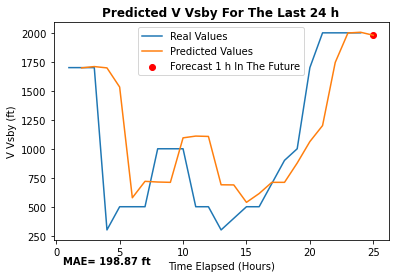

In [21]:
plt.plot(hours, prediction_labels_denorm_V, label='Real Values')
plt.plot(hours_prediction,predicted_denorm_V, label='Predicted Values')
plt.scatter(hour_25,predicted_denorm_V[23], color='red', label='Forecast 1 h In The Future')

error_text_V='MAE= '+str(mean_absolute_error_V)+' ft'
plt.text(0.5,0.5,error_text_V, fontweight="bold")
plt.legend()

units=' (ft)'

plt.ylabel(Variable+units)
plt.xlabel('Time Elapsed (Hours)')
plt.title('Predicted '+Variable+' For The Last 24 h', fontweight="bold")

**Performes the analysis for Horizontal Visibility**

In [22]:
Variable='H Vsby'

In [23]:
wide_window= WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[Variable])

In [24]:
df_normalized=(df-train_historic_mean)/train_historic_std

#Generates an example of a dataset. In the real, the test_df has to be replaced for the las 24 hours
#predict_window = tf.stack([np.array(df[:wide_window.total_window_size])])
predict_window = tf.stack([np.array(df_normalized[len(df_normalized)-wide_window.total_window_size:])])

#Divides into the input and label variables, using the previous dataset and the wide_window Window Type
predict_inputs, predict_labels = wide_window.split_window(predict_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {predict_window.shape}')
print(f'Inputs shape: {predict_inputs.shape}')
print(f'labels shape: {predict_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 25, 7)
Inputs shape: (1, 24, 7)
labels shape: (1, 24, 1)


In [25]:
#Loads the correponding model
path_to_model='201112 Models'+'/'+Airport+'/'+Variable+'.h5'

model = keras.models.load_model(path_to_model)

In [26]:
#Uses the best performed model to predict the label
predicted = model.predict(
    predict_inputs)

In [27]:
predicted_denorm_H=predicted*train_historic_std[Variable]+train_historic_mean[Variable]
predicted_denorm_H=predicted_denorm_H[0]
#As the previous data is standarized, here we calcule the real value for each prediction
prediction_labels_denorm_H=predict_labels*train_historic_std[Variable]+train_historic_mean[Variable]
prediction_labels_denorm_H=prediction_labels_denorm_H[0]

In [28]:
#Measures the MAE
mean_absolute_error_H=np.abs(prediction_labels_denorm_H-predicted_denorm_H).mean()
mean_absolute_error_H=round(mean_absolute_error_H,2)

Text(0.5, 1.0, 'Predicted H Vsby For The Last 24 h')

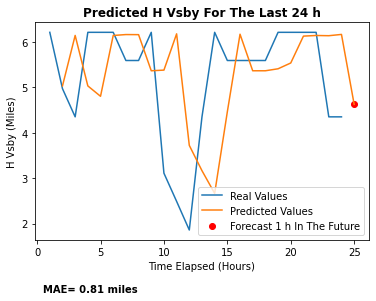

In [29]:
plt.plot(hours, prediction_labels_denorm_H, label='Real Values')
plt.plot(hours_prediction,predicted_denorm_H, label='Predicted Values')
plt.scatter(hour_25,predicted_denorm_H[23], color='red', label='Forecast 1 h In The Future')

error_text_H='MAE= '+str(mean_absolute_error_H)+' miles'
plt.text(0.5,0.5,error_text_H, fontweight="bold")

plt.legend()

units=' (Miles)'

plt.ylabel(Variable+units)
plt.xlabel('Time Elapsed (Hours)')
plt.title('Predicted '+Variable+' For The Last 24 h', fontweight="bold")

**Comparison of Predicted Vs Minimum Values**

In [30]:
minimo=minimos[minimos.index==Airport]
minimo

,H Vsby (miles),V Vsby (ft)
IATA,,
BOG,0.5,220


In [31]:
prediction_V=predicted_denorm_V[23][0]
prediction_V=round(prediction_V, 2)

prediction_H=predicted_denorm_H[23][0]
prediction_H=round(prediction_H, 2)


print(f"Predicted Value for Vertical Visibility is {prediction_V} ft")
print(f"Predicted Value for Horizontal Visibility is {prediction_H} miles")

Predicted Value for Vertical Visibility is 1979.0899658203125 ft
Predicted Value for Horizontal Visibility is 4.619999885559082 miles


In [32]:
Meets_Vertical=prediction_V>minimo['V Vsby (ft)']
Meets_Horizontal=prediction_H>minimo['H Vsby (miles)']

In [33]:
Meets_Vertical

IATA
BOG    True
Name: V Vsby (ft), dtype: bool

In [34]:
Meets_Horizontal

IATA
BOG    True
Name: H Vsby (miles), dtype: bool